### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 2: Insurance Claim Prediction

### Team members: LastName1 FirstName1, LastName2 FirstName2, LastName3 FirstName3

In [10]:
### Import all the Python libraries you are going to use
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
### Fix random seed for reproducibility
np.random.seed(10)

# Exercise 1. Poisson GLM.

In [12]:
# Read csv file
# You can use pandas (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")
mtpl_freq_df = pd.read_csv('freMTPL2freq.csv',
                           sep=';',
                           decimal=',')

In [13]:
mtpl_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB


* there are 5 numerical features and 3 categorical features

In [14]:
# Check that exposure is always positive
all(mtpl_freq_df.Exposure > 0)

True

In [15]:
# Add frequency to the data
mtpl_freq_df['Freq'] = mtpl_freq_df.ClaimNb / mtpl_freq_df.Exposure
mtpl_num_features = mtpl_freq_df.describe().columns
mtpl_freq_df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimNb,Freq
count,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000
mean,6.454653,7.044218,45.499061,59.761588,1792.430975,0.528547,0.038913,0.117907
std,2.050902,5.666235,14.137492,15.636700,3958.663031,0.364081,0.204752,2.002881
min,4.000000,0.000000,18.000000,50.000000,1.000000,0.002732,0.000000,0.000000
25%,5.000000,2.000000,34.000000,50.000000,92.000000,0.180000,0.000000,0.000000
50%,6.000000,6.000000,44.000000,50.000000,393.000000,0.490000,0.000000,0.000000
75%,7.000000,11.000000,55.000000,64.000000,1658.000000,0.990000,0.000000,0.000000
max,15.000000,100.000000,100.000000,230.000000,27000.000000,1.000000,5.000000,365.000000


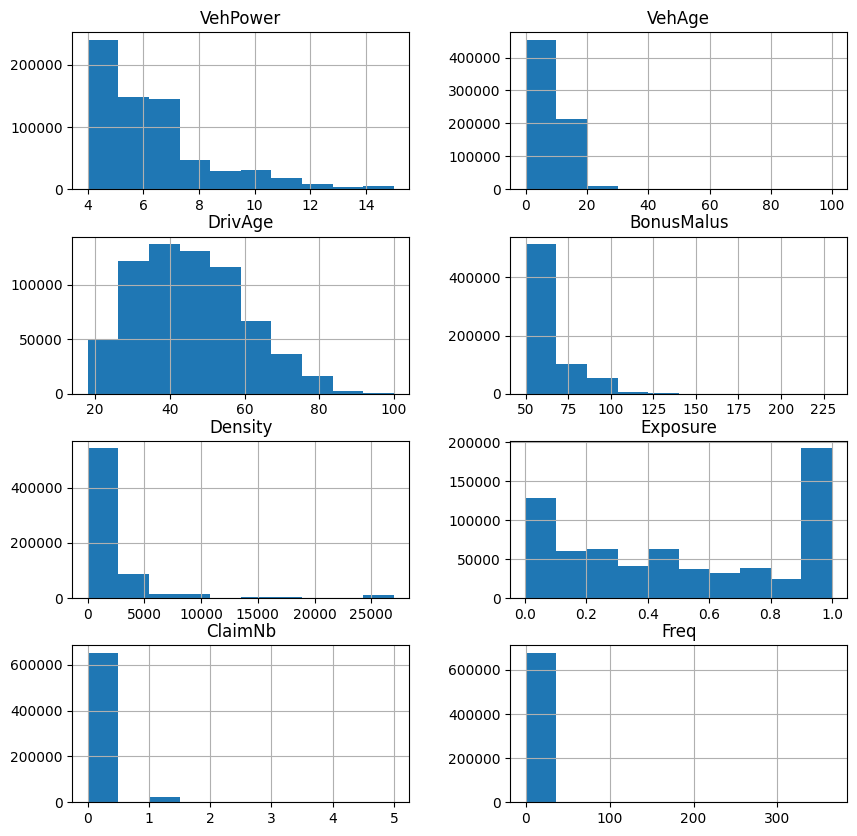

In [16]:
# Lets have a look at the distributions of the numerical features
mtpl_features, mtpl_response = mtpl_freq_df.columns[:-3], mtpl_freq_df.columns[-3:]
mtpl_freq_df.hist(layout=(4,2), figsize=(10,10))
plt.show()

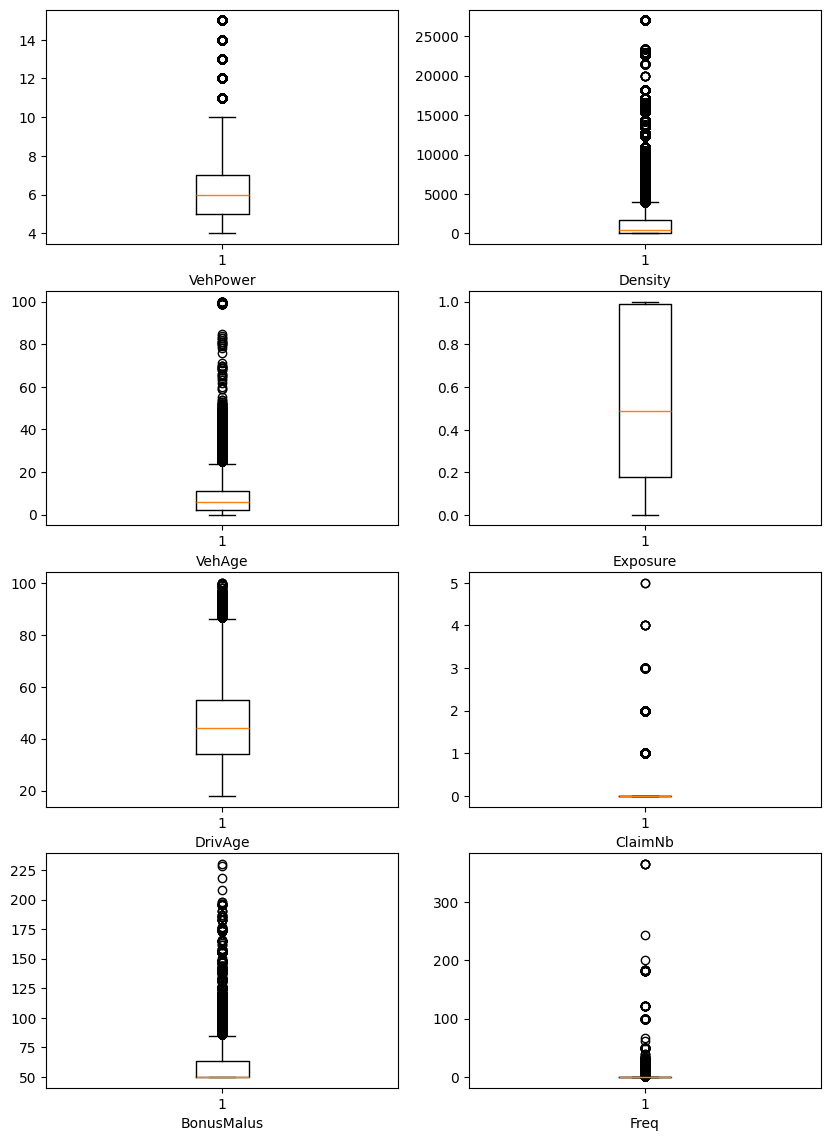

In [17]:
fig, axs = plt.subplots(4, 2, figsize=(10, 14))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].boxplot(mtpl_num_features[(i)+j*axs.shape[0]],data=mtpl_freq_df)
        axs[i,j].set_xlabel(mtpl_num_features[(i)+j*axs.shape[0]])
plt.show()

It seems like many features are skewed and we could benefit from preprocessing the features

In [238]:
# Add extra engineered features to the dataset
mtpl_freq_df['DrivAge2'] = np.power(mtpl_freq_df['DrivAge'],2)
mtpl_freq_df['BonusM_DriveAge'] = mtpl_freq_df['BonusMalus'] * mtpl_freq_df['DrivAge']
mtpl_freq_df['BonusM_DrivAge2'] = mtpl_freq_df['BonusMalus'] * mtpl_freq_df['DrivAge2']

### Preprocessing

In [18]:
X = mtpl_freq_df[mtpl_features]
y = mtpl_freq_df[mtpl_response]

In [73]:
from sklearn.base import TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


class CustomBinner(TransformerMixin):
    def __init__(self, bins, labels):
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.cut(X.iloc[:, 0], bins=self.bins, labels=self.labels)
        return X.values.reshape(-1, 1)



#### Log transformation and binning 

In [183]:
# Pre-process features

# Log transformation
log_transformer = make_pipeline(FunctionTransformer(np.log, validate=True),
                                StandardScaler())
log_features = ['VehPower', 'DrivAge', 'BonusMalus', 'Density']

# Convert VehAge to categorical
bin_features = ['VehAge']
bins = [-np.inf, 5, 12, np.inf]
labels = ['car_0_6', 'car_6_13', 'car_13+']
bin_transformer = make_pipeline(CustomBinner(bins, labels))

preprocessor_log_bin = make_column_transformer(
        (log_transformer, log_features),
        (bin_transformer, bin_features),
        remainder='passthrough')
X_log_bin = preprocessor_log_bin.fit_transform(X)

In [223]:
columns_post_transform = log_features \
                       + bin_features \
                       + X.select_dtypes(include=['object']).columns.tolist()
X_log_bin_df = pd.DataFrame(X_log_bin, columns=columns_post_transform)

In [208]:
X_log_bin_df[log_features] = X_log_bin_df[log_features].astype(float)

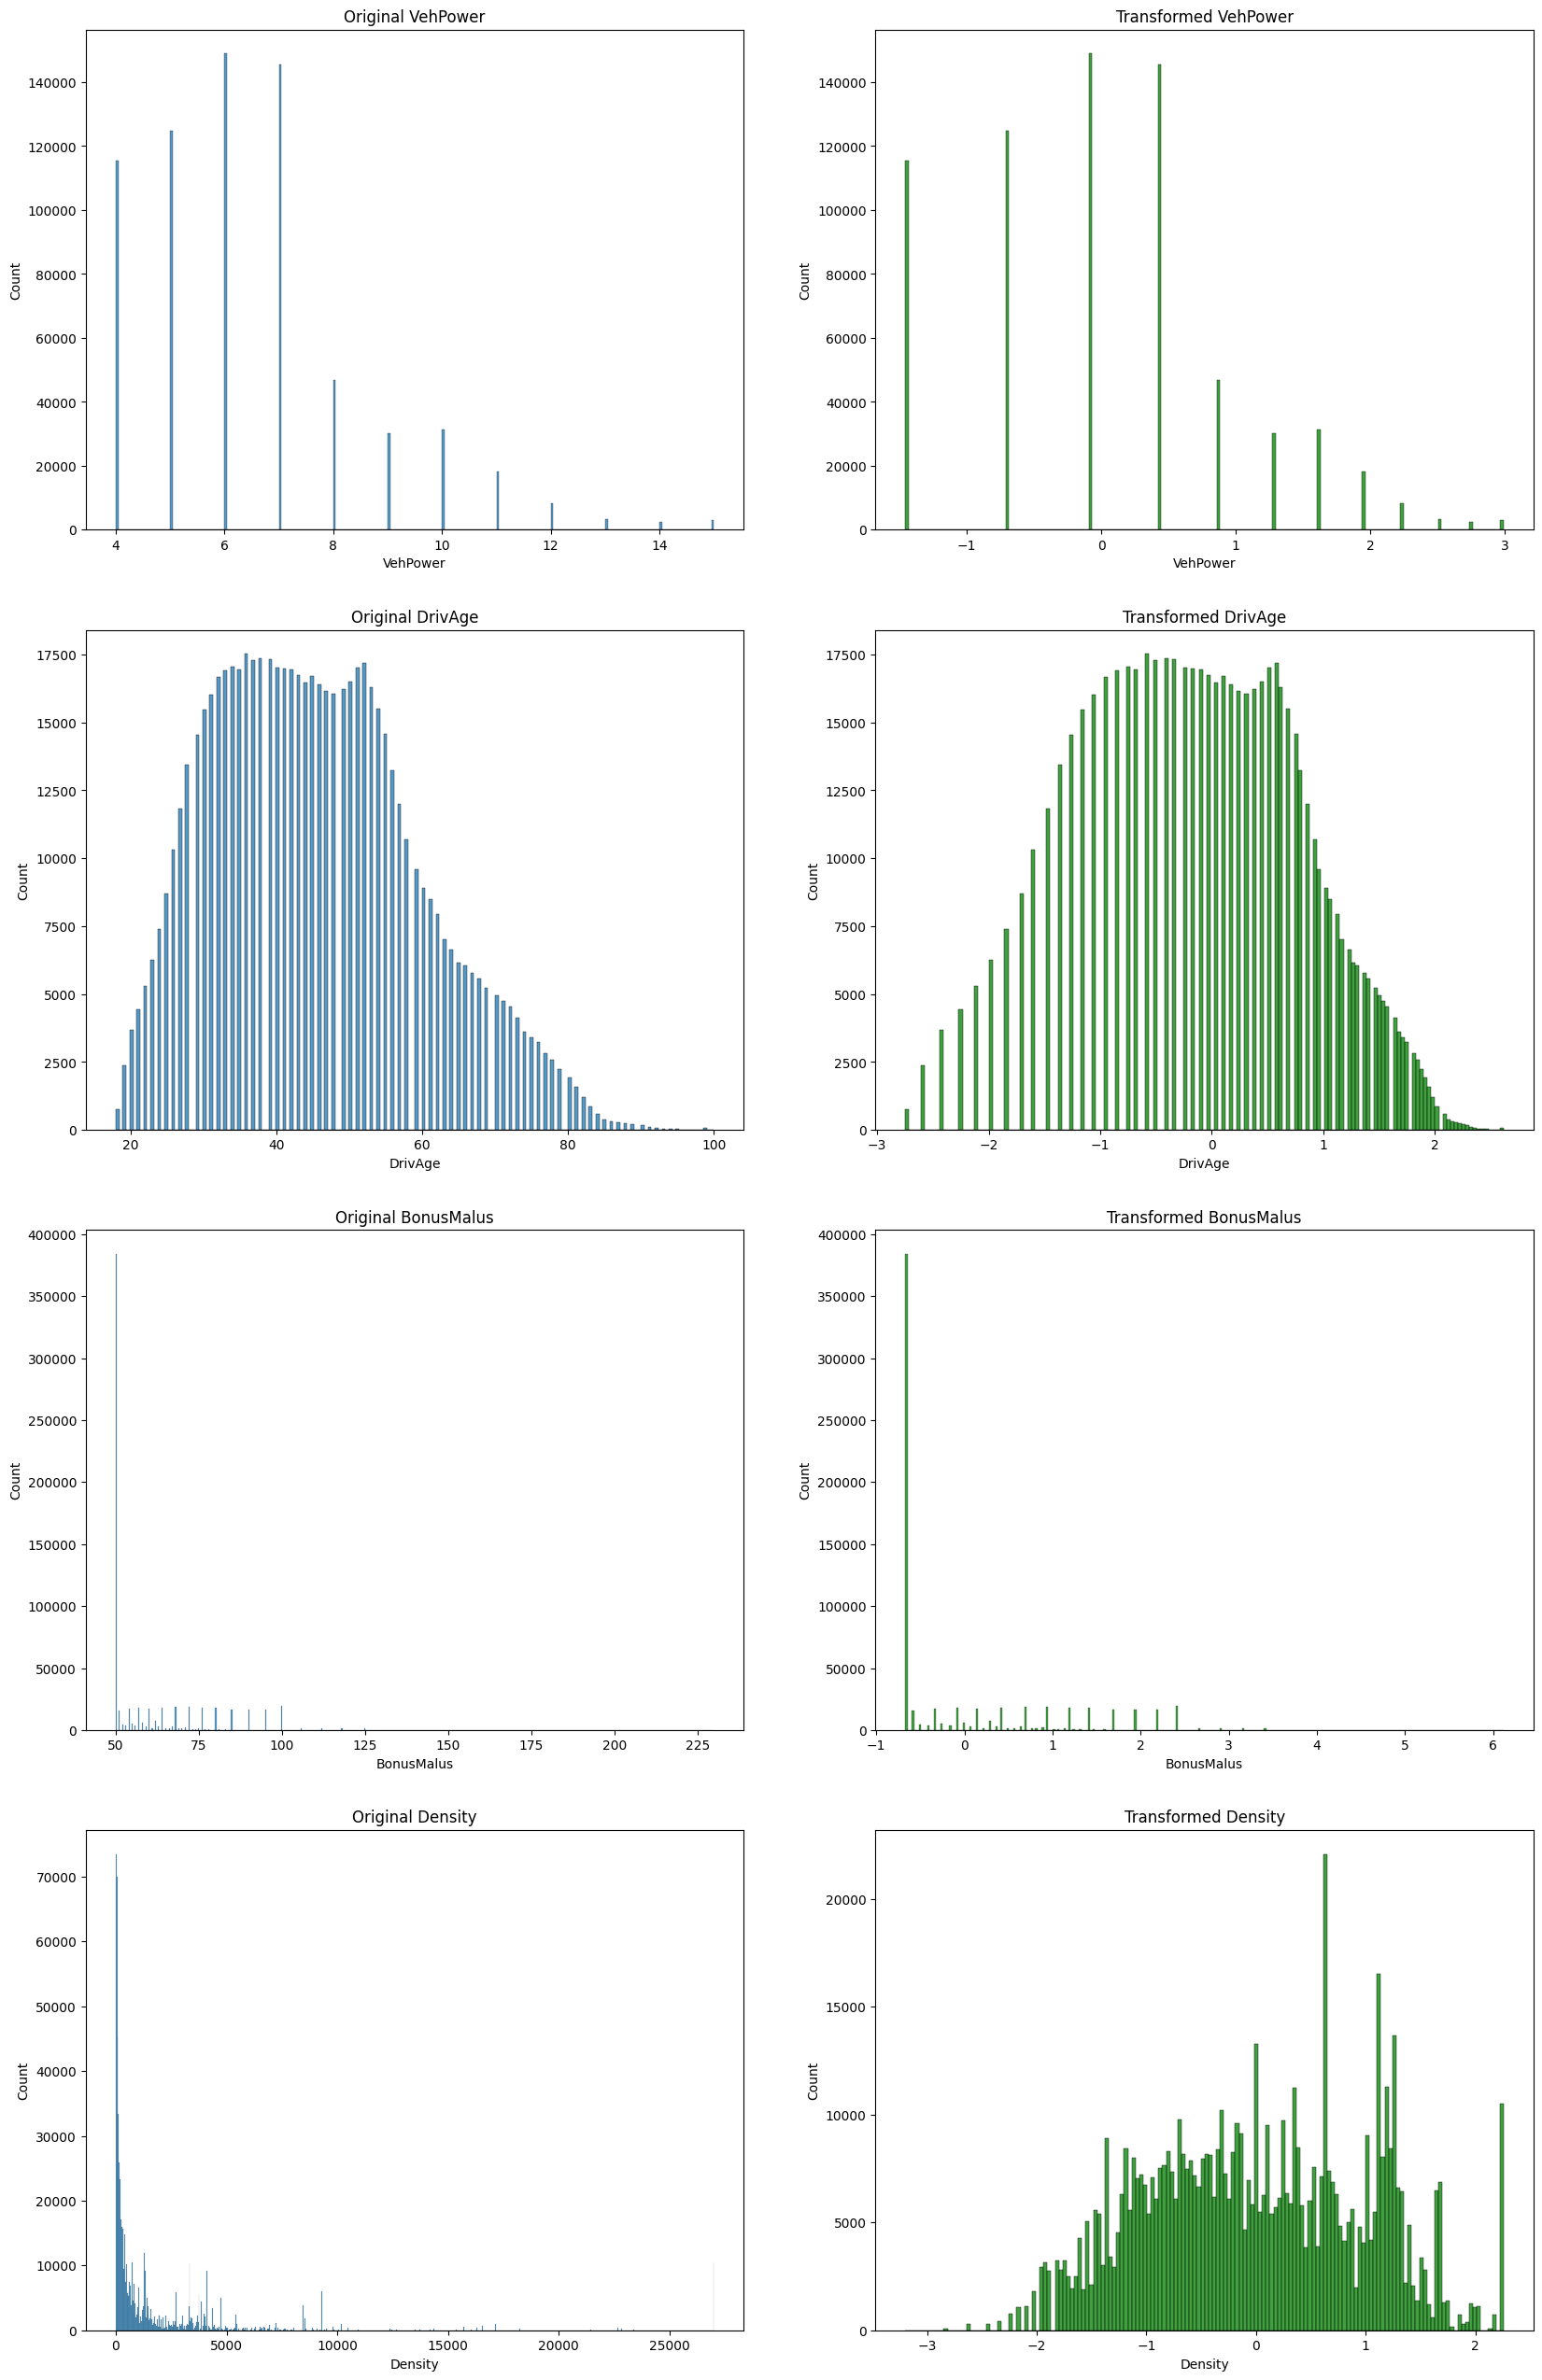

In [221]:
fig, axs = plt.subplots(len(log_features),2, figsize=(20,32))

for i in range(axs.shape[0]):
    # Histogram before transforamtions
    sns.histplot(X[log_features[i]], ax=axs[i,0])
    axs[i, 0].set_title(f'Original {log_features[i]}')

    # Histogram after transforamtions
    sns.histplot(X_log_bin_df[log_features[i]], ax = axs[i,1], color='g')
    axs[i, 1].set_title(f'Transformed {log_features[i]}')

plt.show()

In [224]:
X_log_bin_df[log_features].describe()

,VehPower,DrivAge,BonusMalus,Density
count,6.780070e+05,6.780070e+05,6.780070e+05,6.780070e+05
mean,-2.163046e-17,-2.935706e-15,3.321030e-15,2.501755e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.457228e+00,-2.747022e+00,-6.689602e-01,-3.198020e+00
25%,-7.060744e-01,-7.565577e-01,-6.689602e-01,-7.805442e-01
50%,-9.233693e-02,5.037422e-02,-6.689602e-01,-4.252847e-03
75%,4.265707e-01,7.487502e-01,4.288021e-01,7.653752e-01
max,2.992114e+00,2.619810e+00,6.117261e+00,2.257108e+00


After log transformation and stadarisation all numerical features are of similar scale. Skewness in the data has been also somewhat reduced

#### Dummy encoding

In [234]:
one_hot_features = X.select_dtypes(include=['object']).columns.tolist() + bin_features
total_after_one_hot = 0
for col in one_hot_features:
    level_count = X_log_bin_df[col].unique().size
    print(col, level_count, sep=': ')
    total_after_one_hot += level_count - 1

print(f'number of expected one-hot encoded variables: {total_after_one_hot}')

VehBrand: 11
VehGas: 2
Region: 22
VehAge: 3
number of expected one-hot encoded variables: 34


In [235]:
# One-hot encode categorical
one_hot_transformer_GLM = make_pipeline(OneHotEncoder(handle_unknown='ignore', drop='first'))

preprocessor_one_hot = make_column_transformer(
    (one_hot_transformer_GLM, one_hot_features),
    remainder='passthrough')

X_transformed = preprocessor_one_hot.fit_transform(X_log_bin_df)

In [236]:
# Expect 38 columns (34 one hot encoded and 4 numerical)
X_transformed.shape

(678007, 38)

In [ ]:
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = ['numeric_feature1', 'numeric_feature2']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (one-hot encode them)
categorical_features = ['categorical_feature1', 'categorical_feature2']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Now you have a full prediction pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
# Lets compare features before and after the preprocessing

In [ ]:
# Train-test split


In [34]:
# Train Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")
from sklearn.linear_model import PoissonRegressor


In [ ]:
# Print MAE, MSE and loss on train and test data sets


# Exercise 2. Poisson feedforward neural network.

In [ ]:
# Implement and train a neural network model
# You can use Keras (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")


In [1]:
# Print MAE, MSE and loss on train and test data sets
